In [3]:
%matplotlib inline
import numpy as np # type: ignore
import torch # type: ignore
import pandas as pd # type: ignore
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore
import pickle
import warnings
from sklearn.metrics import confusion_matrix # type: ignore
from pathlib import Path
from DPMoSt import DPMoSt
from utility import data_creation, error_eval, eval_all_roc, plot_solution, new_error_eval # type: ignore
import os
import matplotlib as mpl # type: ignore

import pySuStaIn # type: ignore
import statsmodels.formula.api as smf # type: ignore

In [4]:
warnings.filterwarnings("ignore")

In [5]:
dpi=500

In [6]:
random_state=42
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device='cpu'
print(f'Device used: {device}')

Device used: cpu


In [7]:
plt.style.use('seaborn-v0_8-darkgrid')
color=mpl.colormaps['tab10'].colors
plt.rcParams.update({'font.size': 12})

# Parameters setting

In [8]:
run_data=False
run_dpmost=True
n_sim=100
noise_std=0.5

v_n_features=[2,5,10]
v_n_subjects=[50]
v_n_time_for_subject=[1,2,5,7,10,20]
v_snr=['low', 'medium', 'high']

# Error Evaluation

In [9]:
if not os.path.isfile('simulations/simulations_results.csv'):
    df=pd.DataFrame(columns=['n_features', 'n_subjects', 'n_time_for_subject', 'snr', 'sim', 'feature', 'true_split_number', 'est_split_number', 'error_ospa', 'error_noise'])

    for n_features in v_n_features:
        for n_subjects in v_n_subjects:
            print(f'sim -> features: {n_features}')
            for n_time_for_subject in v_n_time_for_subject:
                for snr in v_snr:
                    name_folder=f'simulations/sim_features_{n_features}_subjects_{n_subjects}_time_points_{n_time_for_subject}_snr_{snr}'
                    for idx in range(n_sim):
                        if os.path.isfile(f'{name_folder}/sol_{idx}.pkl'):
                            with open(f'{name_folder}/data_{idx}.pkl', 'rb') as f:
                                dict_data = pickle.load(f) 
                            with open(f'{name_folder}/sol_{idx}.pkl', 'rb') as f:
                                    dpmost = pickle.load(f)

                            error_ospa, error_noise = error_eval(dpmost, dict_data)
                            error_rate_grouth = new_error_eval(dpmost, dict_data)
                
                            for fdx in range(n_features):
                                df2 = {'n_features': n_features, 'n_subjects': n_subjects, 'n_time_for_subject': n_time_for_subject, 
                                        'snr': snr, 'sim': idx, 'feature': fdx, 'true_split_number': dict_data['n_sig'][fdx].item(), 
                                        'est_split_number': dpmost.est_num[fdx], 'error_rate_grouth': error_rate_grouth[fdx],
                                        'error_ospa': error_ospa[fdx], 'error_noise': error_noise[fdx]}
                                df = df._append(df2, ignore_index=True)
                        else:
                            print(f'missing: {name_folder}/sol_{idx}.pkl')

    df.to_csv('simulations/simulations_results.csv')  
else:
    df = pd.read_csv('simulations/simulations_results.csv')

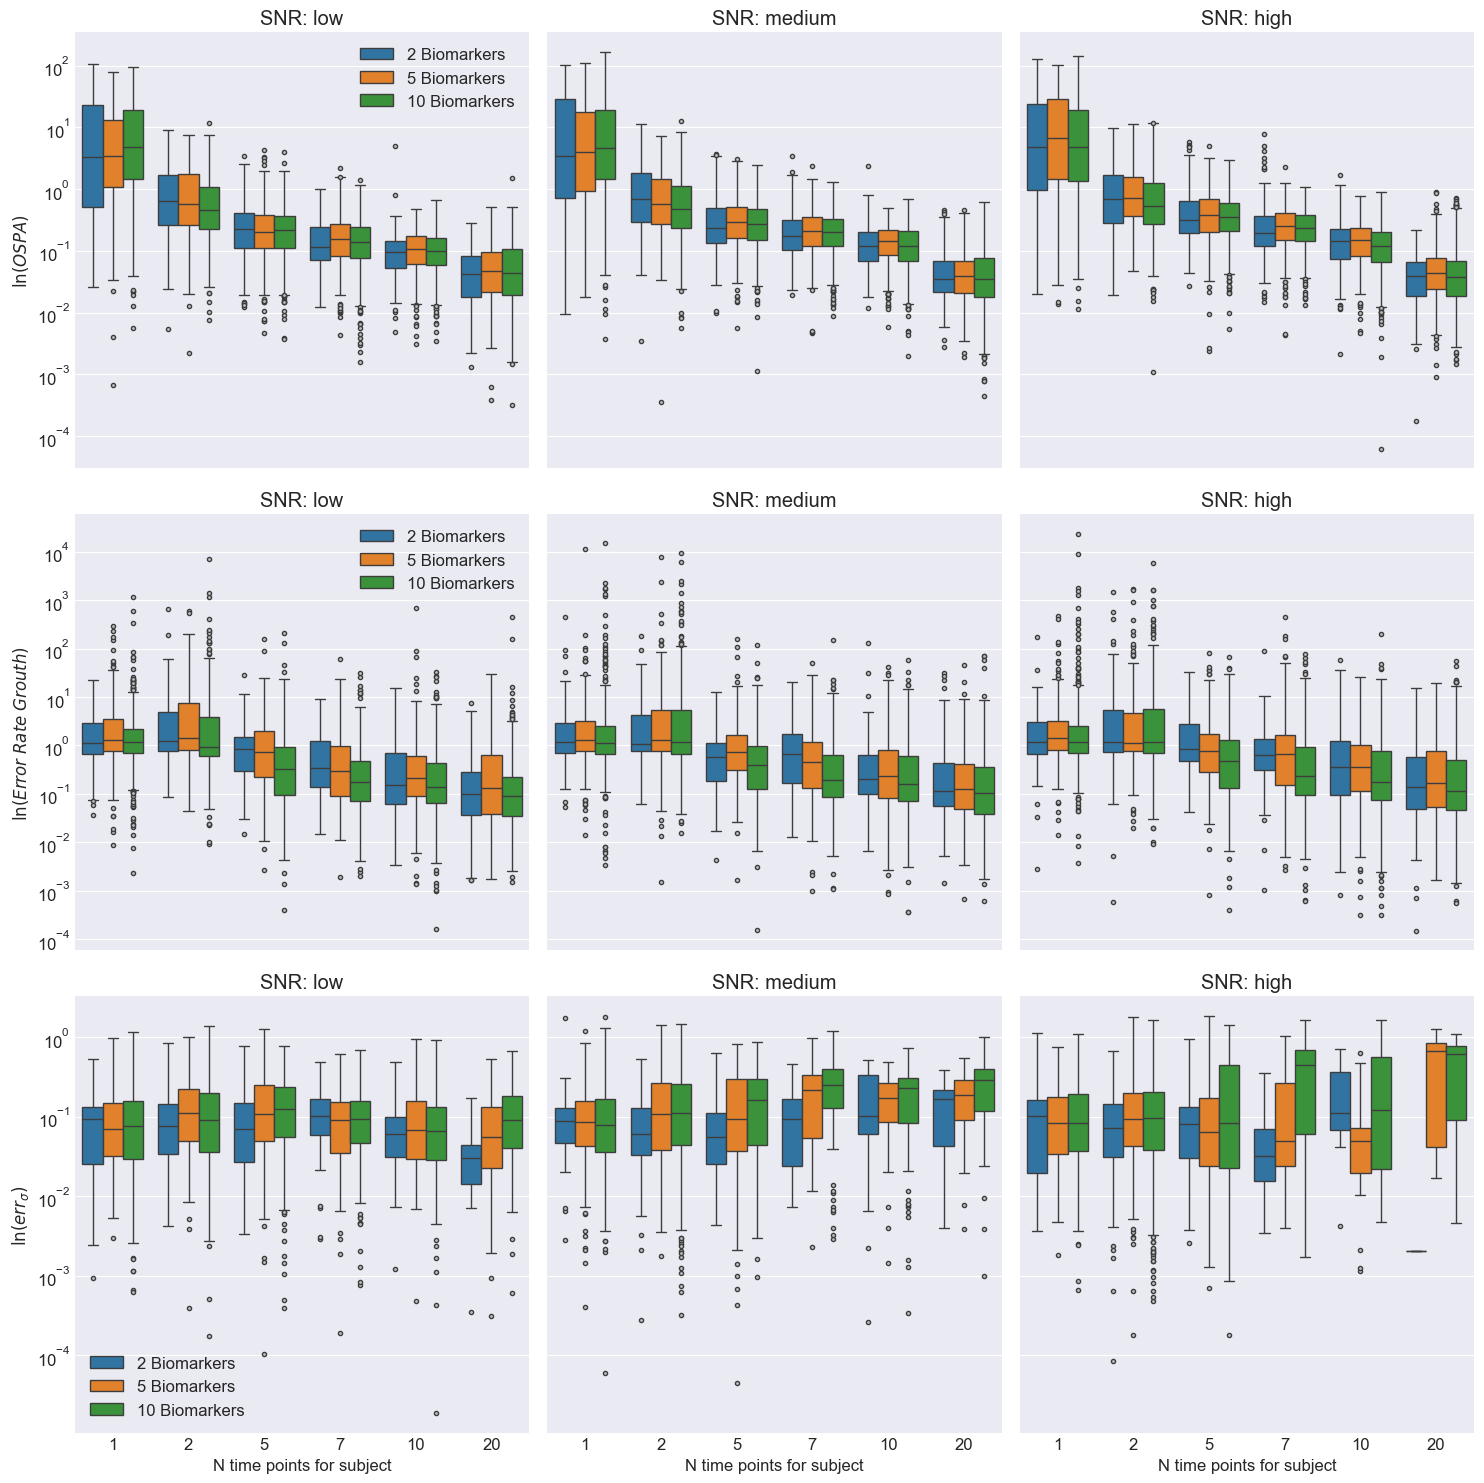

In [11]:
palette=list(np.asanyarray(color)[:df['n_features'].unique().shape[0]])

y_vars=['error_ospa', 'error_rate_grouth', 'error_noise']
y_labels=[r'$\ln(OSPA)$', r'$\ln(Error\;Rate\;Grouth)$',r'$\ln(err_{\sigma})$']

flierprops = dict(markerfacecolor='0.75', markersize=3, marker='o', linewidth=0)

fig,ax=plt.subplots(len(y_vars),len(v_snr),figsize=(5*len(v_snr),5*len(y_vars)), sharex=True, sharey='row')
for ydx, y in enumerate(y_vars):
    for snrdx,snr in enumerate(v_snr):
        plt.sca(ax[ydx,snrdx])
        sns.boxplot(data=df[df['snr']==snr], y=y, x='n_time_for_subject', hue='n_features', log_scale=True, palette=palette, flierprops=flierprops)
        plt.title(f'SNR: {snr}')
        plt.xlabel('N time points for subject')
        plt.ylabel(y_labels[ydx])
        handles, _ = ax[0,0].get_legend_handles_labels()
        plt.legend(handles, ['2 Biomarkers', '5 Biomarkers', '10 Biomarkers'], loc="best")
        if snrdx>0:
            plt.legend().remove()
        #plt.ylim([-10,10])
plt.tight_layout()
plt.savefig('fig_paper/errors_dpmost', dpi=dpi)
plt.show()

In [22]:
def rocs(n_features, n_time_for_subject, snr, v_n_subjects):
    roc_xi=np.zeros(100)
    roc_pi=np.zeros(100)
    for n_subjects in v_n_subjects:
        name_folder=f'simulations/sim_features_{n_features}_subjects_{n_subjects}_time_points_{n_time_for_subject}_snr_{snr}'
        aux_roc_xi, aux_roc_pi, t=eval_all_roc(name_folder, n_sim)
        roc_xi+=aux_roc_xi
        roc_pi+=aux_roc_pi
    roc_xi/=len(v_n_subjects)
    roc_pi/=len(v_n_subjects)

    return t, roc_xi, roc_pi

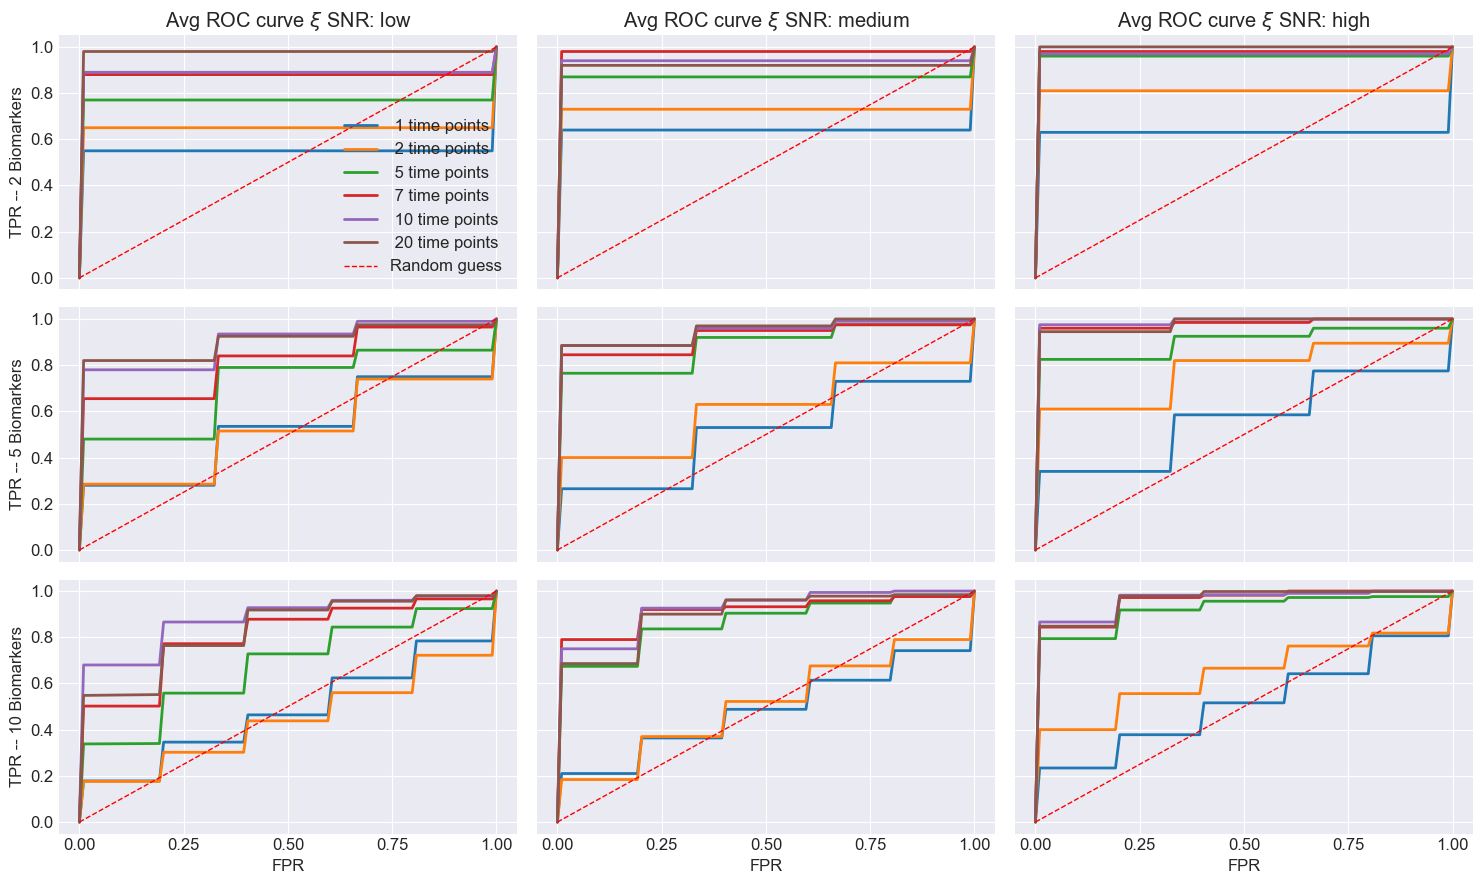

In [23]:
fig,ax=plt.subplots(len(v_n_features),len(v_snr), figsize=(5*len(v_n_features),3*len(v_snr)), sharex=True, sharey=True)
for fdx, n_features in enumerate(v_n_features):
    for snrdx, snr in enumerate(v_snr):
        plt.sca(ax[fdx,snrdx])
        for tdx, n_time_for_subject in enumerate(v_n_time_for_subject):
            t, roc_xi, roc_pi=rocs(n_features, n_time_for_subject, snr, v_n_subjects)
            plt.plot(t, roc_xi, linewidth=2, alpha=1, label=f' {n_time_for_subject} time points')
        plt.plot([0, 1], [0, 1], linestyle='--', linewidth=1, color='r', label='Random guess')
        plt.xticks([0, 0.25, 0.5, 0.75, 1])
        if fdx==0 and snrdx==0: plt.legend()
        else: plt.legend().remove()
        if fdx==len(v_n_features)-1: plt.xlabel('FPR')
        if snrdx==0: plt.ylabel(f'TPR -- {n_features} Biomarkers')
        if fdx==0: plt.title(r'Avg ROC curve $\xi$' + f' SNR: {snr}')
plt.tight_layout()
plt.savefig('fig_paper/roc_xi_dpmost', dpi=dpi)
plt.show()

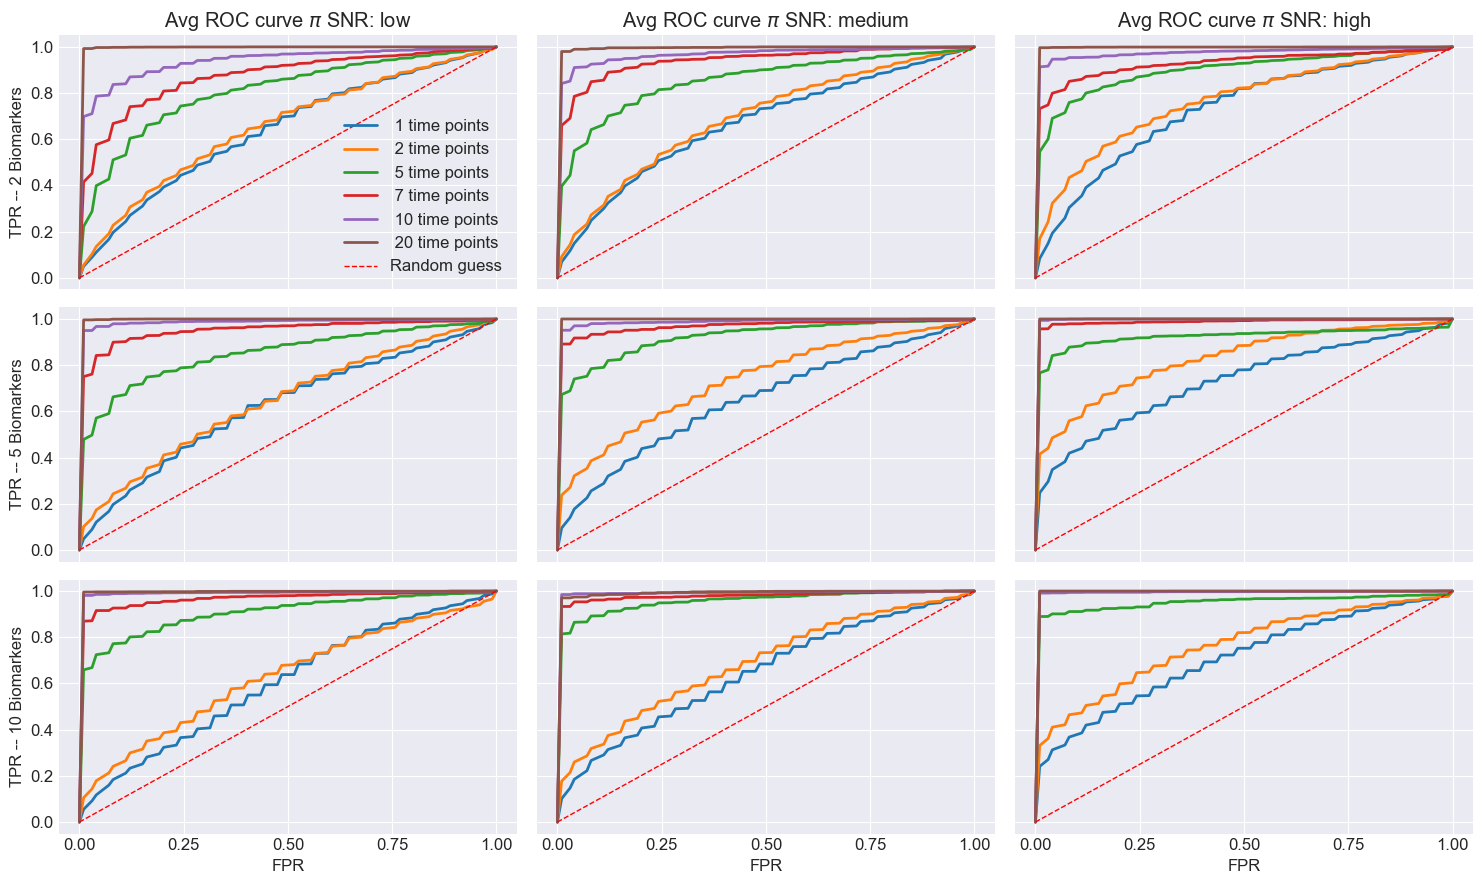

In [24]:
fig,ax=plt.subplots(len(v_n_features),len(v_snr), figsize=(5*len(v_n_features),3*len(v_snr)), sharex=True, sharey=True)
for fdx, n_features in enumerate(v_n_features):
    for snrdx, snr in enumerate(v_snr):
        plt.sca(ax[fdx,snrdx])
        for tdx, n_time_for_subject in enumerate(v_n_time_for_subject):
            t, roc_xi, roc_pi=rocs(n_features, n_time_for_subject, snr, v_n_subjects)
            plt.plot(t, roc_pi, linewidth=2, alpha=1, label=f' {n_time_for_subject} time points')
        plt.plot([0, 1], [0, 1], linestyle='--', linewidth=1, color='r', label='Random guess')
        plt.xticks([0, 0.25, 0.5, 0.75, 1])
        if fdx==0 and snrdx==0: plt.legend()
        else: plt.legend().remove()
        if fdx==len(v_n_features)-1: plt.xlabel('FPR')
        if snrdx==0: plt.ylabel(f'TPR -- {n_features} Biomarkers')
        if fdx==0: plt.title(r'Avg ROC curve $\pi$' + f' SNR: {snr}')
plt.tight_layout()
plt.savefig('fig_paper/roc_pi_dpmost', dpi=dpi)
plt.show()

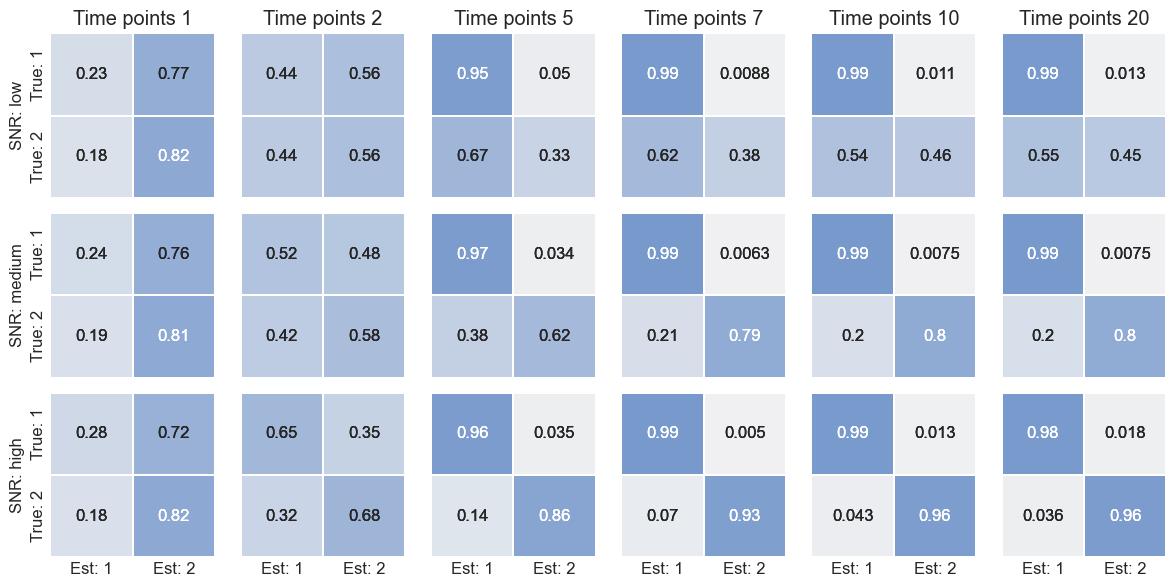

In [25]:
cmap=sns.light_palette("#79C", as_cmap=True)

fig,ax=plt.subplots(len(v_snr), len(v_n_time_for_subject), figsize=(4*len(v_snr), len(v_n_time_for_subject)), sharex=True, sharey=True)

for n_features in v_n_features:
    for n_subjects in v_n_subjects:
        for ntimedx, n_time_for_subject in enumerate(v_n_time_for_subject):
            for snrdx, snr in enumerate(v_snr):

                df_aux=df[(df['n_time_for_subject']==n_time_for_subject)&(df['snr']==snr)].copy()

                true=df_aux['true_split_number'].values.astype(int)
                pred=df_aux['est_split_number'].values.astype(int)

                cm=confusion_matrix(true, pred, normalize='true')
                plt.sca(ax[snrdx, ntimedx])
                sns.heatmap(cm, annot=True, fmt='.2g', cmap=cmap, linewidths=.05, cbar=False, center=0.5, square=True, vmin=0, vmax=1)
                if ntimedx==0: plt.ylabel(f'SNR: {snr}')
                if snrdx==0: plt.title(f'Time points {n_time_for_subject}')
                #if snrdx==len(v_snr)-1: plt.xlabel('Predicted')
                plt.xticks([0.5,1.5],['Est: 1', 'Est: 2'])
                plt.yticks([0.5,1.5],['True: 1', 'True: 2'], rotation=90)
plt.tight_layout()
plt.savefig('fig_paper/confusion_matrix_dpmost', dpi=dpi)
plt.show()

# Sustain

In [58]:
N_iterations_MCMC=int(1e4)
N_S_max=2

In [172]:
if not os.path.isfile('simulations/simulations_sustain_results.csv'):
    df_sustain=pd.DataFrame(columns=['n_features', 'n_subjects', 'n_time_for_subject', 'snr', 'sim', 'feature', 'true_split_number', 'est_split_number'])
    for n_features in v_n_features:
        for n_subjects in v_n_subjects:
            print(f'sim -> features: {n_features}')
            for n_time_for_subject in v_n_time_for_subject:
                for snr in v_snr:
                    name_folder=f'simulations/sim_features_{n_features}_subjects_{n_subjects}_time_points_{n_time_for_subject}_snr_{snr}'
                    for idx in range(n_sim):
                        if os.path.isfile(name_folder + '/pickle_files/sustain_sol_' + str(idx) + '_subtype0.pickle'):
                            with open(f'{name_folder}/data_{idx}.pkl', 'rb') as f:
                                dict_data = pickle.load(f) 

                            like_mean=[]
                            for s in range(N_S_max):
                                pickle_filename_s = name_folder + '/pickle_files/sustain_sol_' + str(idx) + '_subtype' + str(s) + '.pickle'
                                pk = pd.read_pickle(pickle_filename_s)
                                samples_likelihood = pk["samples_likelihood"].flatten()
                                like_mean.append(samples_likelihood.mean())

                            est_num=np.argmax(np.asarray(like_mean))+1
                
                            for fdx in range(n_features):
                                df2 = {'n_features': n_features, 'n_subjects': n_subjects, 'n_time_for_subject': n_time_for_subject, 
                                        'snr': snr, 'sim': idx, 'feature': fdx, 'true_split_number': dict_data['n_sig'][fdx].item(), 
                                        'est_split_number': est_num}
                                df_sustain = df_sustain._append(df2, ignore_index=True)
                        else:
                            print(name_folder)
                            print(idx)
                            print('\n')

    df_sustain.to_csv('simulations/simulations_sustain_results.csv')  
else: 
    df_sustain = pd.read_csv('simulations/simulations_sustain_results.csv')

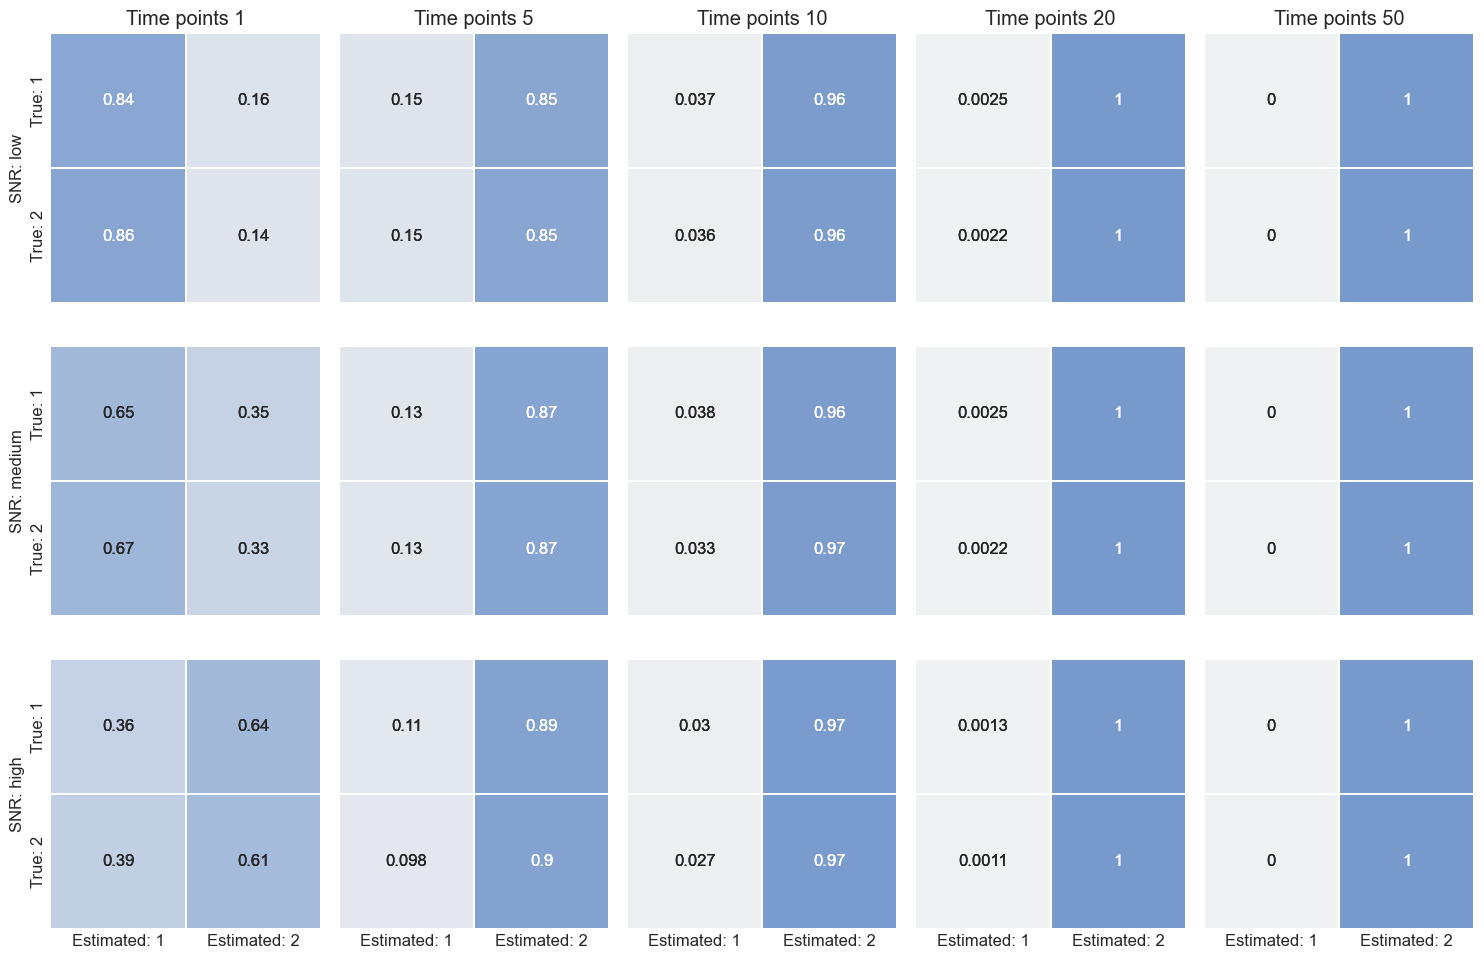

In [173]:
cmap=sns.light_palette("#79C", as_cmap=True)

fig,ax=plt.subplots(len(v_snr), len(v_n_time_for_subject), figsize=(5*len(v_snr), 2*len(v_n_time_for_subject)), sharex=True, sharey=True)

for n_features in v_n_features:
    for n_subjects in v_n_subjects:
        for ntimedx, n_time_for_subject in enumerate(v_n_time_for_subject):
            for snrdx, snr in enumerate(v_snr):

                df_aux=df_sustain[(df_sustain['n_time_for_subject']==n_time_for_subject)&(df_sustain['snr']==snr)].copy()

                true=df_aux['true_split_number'].values.astype(int)
                pred=df_aux['est_split_number'].values.astype(int)

                cm=confusion_matrix(true, pred, normalize='true')
                plt.sca(ax[snrdx, ntimedx])
                sns.heatmap(cm, annot=True, fmt='.2g', cmap=cmap, linewidths=.05, cbar=False, center=0.5, square=True, vmin=0, vmax=1)
                if ntimedx==0: plt.ylabel(f'SNR: {snr}')
                if snrdx==0: plt.title(f'Time points {n_time_for_subject}')
                #if snrdx==len(v_snr)-1: plt.xlabel('Predicted')
                plt.xticks([0.5,1.5],['Estimated: 1', 'Estimated: 2'])
                plt.yticks([0.5,1.5],['True: 1', 'True: 2'], rotation=90)
plt.tight_layout()
plt.show()

In [79]:
pk = pd.read_pickle(pickle_filename_s)
samples_sequence = pk['samples_sequence']
samples_f = pk['samples_f']

In [ ]:
# sustain into something readable

In [119]:
variance_by_group = db_aux.groupby('subj_id')['prob'].var()
variance_by_group.mean()

0.021665584508417855

In [174]:
from scipy import interpolate
from sklearn.metrics import roc_curve, auc

In [183]:
def eval_roc_pi_sustain(name_folder, idx):
    if os.path.isfile(name_folder + '/pickle_files/sustain_sol_' + str(idx) + '_subtype0.pickle') and os.path.isfile(name_folder + '/pickle_files/sustain_sol_' + str(idx) + '_subtype1.pickle'):
        with open(f'{name_folder}/data_{idx}.pkl', 'rb') as f:
            dict_data = pickle.load(f) 

        like_mean=[]
        for s in range(2):
            pickle_filename_s = name_folder + '/pickle_files/sustain_sol_' + str(idx) + '_subtype' + str(s) + '.pickle'
            pk = pd.read_pickle(pickle_filename_s)
            samples_likelihood = pk["samples_likelihood"].flatten()
            like_mean.append(samples_likelihood.mean())

        s=np.argmax(np.asarray(like_mean))+1

        pk = pd.read_pickle(pickle_filename_s)
        samples_sequence = pk['samples_sequence']
        samples_f = pk['samples_f']

        db_aux=pd.DataFrame()
        prob=[]
        for i in range(pk['prob_subtype'][:,s-1].shape[0]): 
            prob.append(pk['prob_subtype'][:,s-1][i])  

        db_aux['subj_id']=dict_data['data']['subj_id']
        db_aux['prob']=prob 

        est_subpop_sustain = db_aux.groupby('subj_id')['prob'].agg('mean').reset_index()['prob']

        fpr, tpr, _=roc_curve(dict_data['pi_true'], est_subpop_sustain)
        fpr_2, tpr_2, _=roc_curve(dict_data['pi_true'], est_subpop_sustain)

        auc_1 = auc(fpr, tpr)
        auc_2 = auc(fpr_2, tpr_2)
        if auc_1<auc_2 and tpr_2[0]==0:
            tpr=tpr_2
            fpr=fpr_2
        f = interpolate.interp1d(fpr, tpr)
        roc=f(t)

        roc[0]=0
        roc[-1]=1
        return roc
    else:
        return 0
    
def rocs_sustain(name_folder):
    roc=0
    for idx in range(n_sim):
        roc+=eval_roc_pi_sustain(name_folder, idx)

    return roc/n_sim

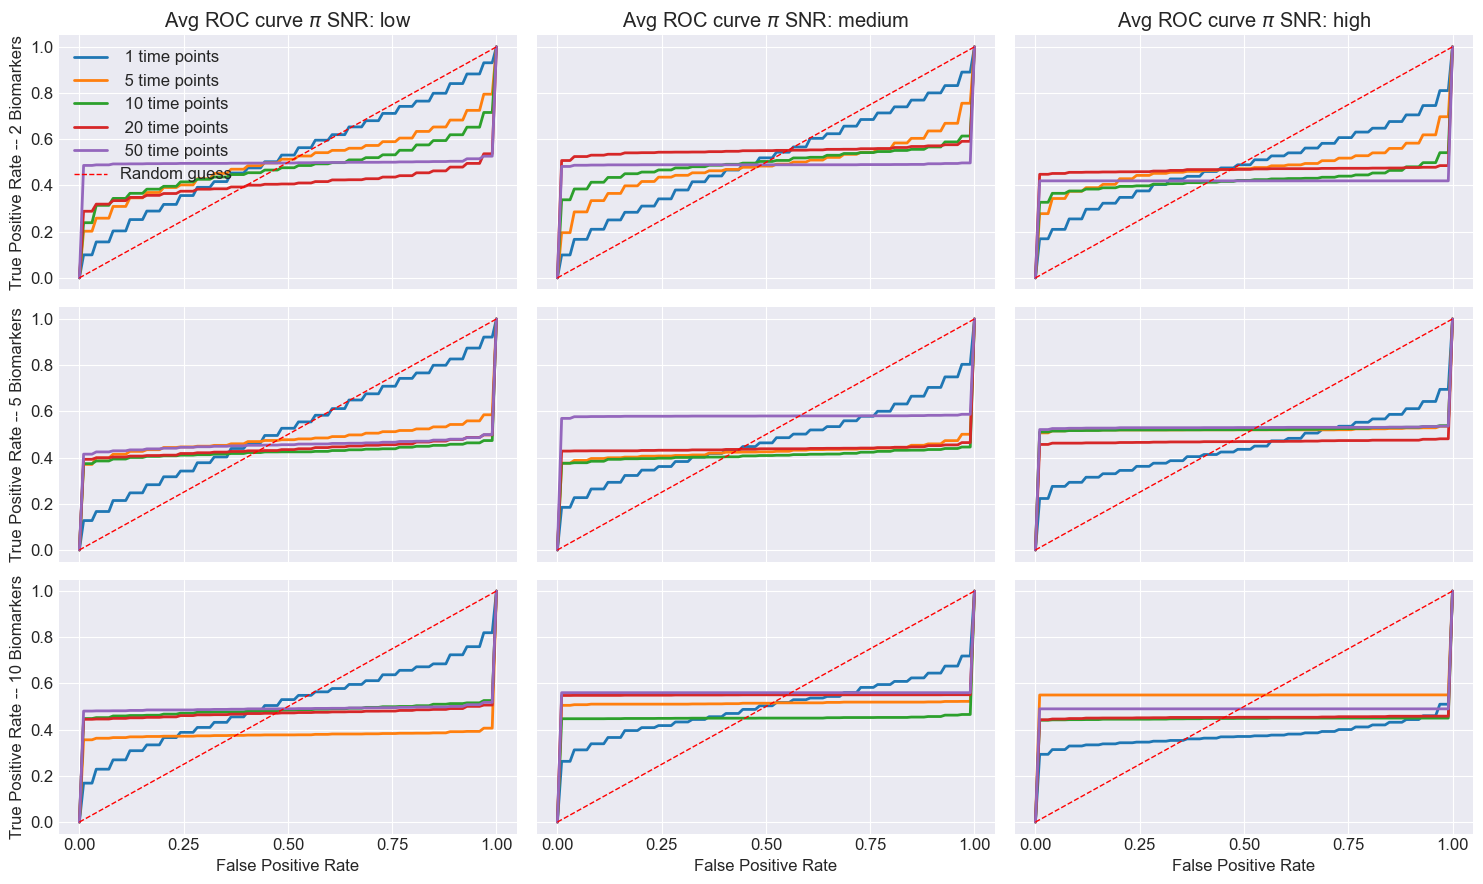

In [184]:
fig,ax=plt.subplots(len(v_n_features),len(v_snr), figsize=(5*len(v_n_features),3*len(v_snr)), sharex=True, sharey=True)
for fdx, n_features in enumerate(v_n_features):
    for snrdx, snr in enumerate(v_snr):
        plt.sca(ax[fdx,snrdx])
        for tdx, n_time_for_subject in enumerate(v_n_time_for_subject):
            name_folder=f'simulations/sim_features_{n_features}_subjects_{n_subjects}_time_points_{n_time_for_subject}_snr_{snr}'
            roc_pi_sustain=rocs_sustain(name_folder)
            plt.plot(t, roc_pi_sustain, linewidth=2, alpha=1, label=f' {n_time_for_subject} time points')
        plt.plot([0, 1], [0, 1], linestyle='--', linewidth=1, color='r', label='Random guess')
        plt.xticks([0, 0.25, 0.5, 0.75, 1])
        if fdx==0 and snrdx==0: plt.legend()
        else: plt.legend().remove()
        if fdx==len(v_n_features)-1: plt.xlabel('False Positive Rate')
        if snrdx==0: plt.ylabel(f'True Positive Rate -- {n_features} Biomarkers')
        if fdx==0: plt.title(r'Avg ROC curve $\pi$' + f' SNR: {snr}')
plt.tight_layout()
plt.show()

In [ ]:
for fdx, n_features in enumerate(v_n_features):
    for snrdx, snr in enumerate(v_snr):
        for tdx, n_time_for_subject in enumerate(v_n_time_for_subject):
            for idx in range(n_sim):
                name_folder=f'simulations/sim_features_{n_features}_subjects_{n_subjects}_time_points_{n_time_for_subject}_snr_{snr}'

In [186]:
variance_by_group = db_aux.groupby('subj_id')['prob_subtype'].var()

KeyError: 'Column not found: prob_subtype'

In [108]:
def most_frequent(series):
    return series.mode().iloc[0]
est_subpop_sustain = db_aux.groupby('subj_id')['est_subpop'].agg(most_frequent).reset_index()

In [ ]:
s = 1
for variable in ['ml_subtype', # the assigned subtype
                 'prob_ml_subtype', # the probability of the assigned subtype
                 'ml_stage', # the assigned stage 
                 'prob_ml_stage',]: # the probability of the assigned stage
    
    # add SuStaIn output to dataframe
    zdata.loc[:,variable] = pk[variable] 

# let's also add the probability for each subject of being each subtype
for i in range(s):
    zdata.loc[:,'prob_S%s'%i] = pk['prob_subtype'][:,i]
zdata.head()

In [124]:
zdata = dict_data['data'].copy()
# for each biomarker
for biomarker in zdata.columns[2:]:
    mod = smf.ols('%s ~ time'%biomarker, data=zdata).fit()    
    predicted = mod.predict(zdata[['time',biomarker]])     
    w_score = (zdata.loc[:,biomarker] - predicted) / mod.resid.std()
    zdata.loc[:,biomarker] = w_score

In [127]:
Z_vals = np.array([[0.5,1,1.5]]*dict_data['n_features']) # Z-scores for each biomarker
Z_max = np.array([5]*dict_data['n_features']) # maximum z-score
N_S_max=2
N_iterations_MCMC=int(1e4)

sustain_input = pySuStaIn.ZscoreSustain(
                                        zdata[zdata.columns[2:]].values,
                                        Z_vals=Z_vals,
                                        Z_max=Z_max,
                                        biomarker_labels=zdata.columns[2:],
                                        N_startpoints=15,
                                        N_S_max=N_S_max, 
                                        N_iterations_MCMC=N_iterations_MCMC, 
                                        output_folder=name_folder, 
                                        dataset_name=f'sustain_sol_{idx}', 
                                        use_parallel_startpoints=True)

pySuStaIn.ZscoreSustain._plot_sustain_model(sustain_input,samples_sequence,samples_f,n_samples=50,subtype_order=(0,1))

([<Figure size 640x480 with 2 Axes>],
 array([<Axes: title={'center': 'Subtype 1 (f=0.51, n=25)'}, xlabel='SuStaIn Stage'>,
        <Axes: title={'center': 'Subtype 2 (f=0.49, n=25)'}, xlabel='SuStaIn Stage'>],
       dtype=object))

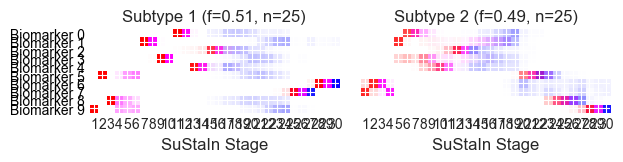